In [4]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np


In [5]:
# Carrega o dataset completo com preços, geração, load, e clima
df = pd.read_csv("dataset.csv", parse_dates=['time'])
df.set_index('time', inplace=True)

# Verifica se a coluna de preço está presente
print(df.columns[df.columns.str.contains("price", case=False)])


Index(['price day ahead', 'price actual'], dtype='object')


In [6]:
def add_lag_and_time_features(df):
    df = df.copy()
    df['lag_1h'] = df['price actual'].shift(1)
    df['lag_24h'] = df['price actual'].shift(24)
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['dow_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['dow_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    return df.dropna()

df_prepared = add_lag_and_time_features(df)


In [7]:
def create_custom_sliding_windows(df):
    """
    Cria janelas fixas com:
    - Janela 1: treino 2015, teste 2016
    - Janela 2: treino 2015-2016, teste 2017
    - Janela 3: treino 2015–2017, teste 2018
    """
    df = df.copy()
    df = df.sort_index()

    splits = []

    configs = [
        ('2015-01-01', '2015-12-31', '2016-01-01', '2016-12-31'),  # Janela 1
        ('2015-01-01', '2016-12-31', '2017-01-01', '2017-12-31'),  # Janela 2
        ('2015-01-01', '2017-12-31', '2018-01-01', '2018-12-31'),  # Janela 3
    ]

    for train_start, train_end, test_start, test_end in configs:
        df_train = df.loc[train_start:train_end]
        df_test = df.loc[test_start:test_end]
        splits.append((df_train, df_test))

    return splits

# Criar os splits
splits = create_custom_sliding_windows(df_prepared)

# Visualizar os períodos
for i, (train, test) in enumerate(splits, start=1):
    print(f"Janela {i}:")
    print(f"  Treino: {train.index.min().date()} → {train.index.max().date()}  ({len(train)} registos)")
    print(f"  Teste:  {test.index.min().date()} → {test.index.max().date()}  ({len(test)} registos)\n")


Janela 1:
  Treino: 2015-01-01 → 2015-12-31  (8737 registos)
  Teste:  2016-01-01 → 2016-12-31  (8784 registos)

Janela 2:
  Treino: 2015-01-01 → 2016-12-31  (17521 registos)
  Teste:  2017-01-01 → 2017-12-31  (8760 registos)

Janela 3:
  Treino: 2015-01-01 → 2017-12-31  (26281 registos)
  Teste:  2018-01-01 → 2018-12-31  (8759 registos)



In [8]:
forecast_horizon = 168
df_prepared['target'] = df_prepared['price actual'].shift(-forecast_horizon)
df_prepared = df_prepared.dropna(subset=['target'])

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import pandas as pd
import numpy as np

def longterm_sliding_expanding_linear_regression(df, train_start, train_end, test_start, test_end, forecast_horizon=168):
    df = df.copy()
    df.index = df.index.tz_localize(None)
    
    current_test_start = pd.to_datetime(test_start)
    final_test_end = pd.to_datetime(test_end)

    # Hiperparâmetros (ajustáveis)
    fit_intercept = True
    normalize = False  # já usamos StandardScaler

    results = []
    
    total_steps = ((final_test_end - current_test_start).days + 1) // 7
    checkpoints = {int(total_steps * 0.25): "25%", int(total_steps * 0.5): "50%", int(total_steps * 0.75): "75%"}

    step = 0
    while current_test_start + pd.Timedelta(hours=forecast_horizon - 1) <= final_test_end:
        if step in checkpoints:
            print(f"⏳ Progresso: {checkpoints[step]} da janela de teste")

        current_test_end = current_test_start + pd.Timedelta(hours=forecast_horizon - 1)

        df_train = df.loc[train_start:current_test_start - pd.Timedelta(hours=1)]
        df_test = df.loc[current_test_start:current_test_end]

        drop_cols = ['price actual', 'price day ahead']
        feature_cols = [col for col in df.columns if col not in drop_cols]

        X_train = df_train[feature_cols].values
        y_train = df_train['price actual'].values
        X_test = df_test[feature_cols].values
        y_test = df_test['price actual'].values

        # Escalamento
        scaler_X = StandardScaler()
        scaler_y = StandardScaler()
        X_train_scaled = scaler_X.fit_transform(X_train)
        X_test_scaled = scaler_X.transform(X_test)
        y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()

        # Modelo
        model = LinearRegression(fit_intercept=fit_intercept)
        model.fit(X_train_scaled, y_train_scaled)

        y_pred_scaled = model.predict(X_test_scaled)
        y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

        # Métricas
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mape = mean_absolute_percentage_error(y_test, y_pred) * 100
        rmae = mae / np.mean(np.abs(y_test))

        results.append({
            'start': current_test_start,
            'end': current_test_end,
            'MAE': mae,
            'RMSE': rmse,
            'MAPE (%)': mape,
            'rMAE': rmae
        })

        # Avançar + contar progresso
        current_test_start += pd.Timedelta(hours=forecast_horizon)
        step += 1

    return pd.DataFrame(results)


In [7]:
results_lr_window1 = longterm_sliding_expanding_linear_regression(
    df,
    train_start='2015-01-01',
    train_end='2015-12-31',
    test_start='2016-01-01',
    test_end='2016-12-31'
)

mean_metrics = results_lr_window1[['MAE', 'RMSE', 'MAPE (%)', 'rMAE']].mean()
print("📊 Métricas médias - Linear Regression (Window 2):")
print(mean_metrics.round(4))

results_lr_window2 = longterm_sliding_expanding_linear_regression(
    df,
    train_start='2015-01-01',
    train_end='2016-12-31',
    test_start='2017-01-01',
    test_end='2017-12-31'
)

mean_metrics = results_lr_window2[['MAE', 'RMSE', 'MAPE (%)', 'rMAE']].mean()
print("📊 Métricas médias - Linear Regression (Window 2):")
print(mean_metrics.round(4))

results_lr_window3 = longterm_sliding_expanding_linear_regression(
    df,
    train_start='2015-01-01',
    train_end='2017-12-31',
    test_start='2018-01-01',
    test_end='2018-12-31'
)

mean_metrics = results_lr_window3[['MAE', 'RMSE', 'MAPE (%)', 'rMAE']].mean()
print("📊 Métricas médias - Linear Regression (Window 2):")
print(mean_metrics.round(4))

⏳ Progresso: 25% da janela de teste
⏳ Progresso: 50% da janela de teste
⏳ Progresso: 75% da janela de teste
📊 Métricas médias - Linear Regression (Window 2):
MAE          8.9377
RMSE        10.4037
MAPE (%)    22.5861
rMAE         0.2000
dtype: float64
⏳ Progresso: 25% da janela de teste
⏳ Progresso: 50% da janela de teste
⏳ Progresso: 75% da janela de teste
📊 Métricas médias - Linear Regression (Window 2):
MAE          8.0674
RMSE         9.8431
MAPE (%)    13.3984
rMAE         0.1316
dtype: float64
⏳ Progresso: 25% da janela de teste
⏳ Progresso: 50% da janela de teste
⏳ Progresso: 75% da janela de teste
📊 Métricas médias - Linear Regression (Window 2):
MAE          8.6435
RMSE        10.0758
MAPE (%)    14.9051
rMAE         0.1378
dtype: float64


In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import pandas as pd
import numpy as np

def longterm_sliding_expanding_rf(
    df,
    train_start,
    train_end,
    test_start,
    test_end,
    forecast_horizon=168,
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
):
    df = df.copy()
    df.index = df.index.tz_localize(None)
    
    current_test_start = pd.to_datetime(test_start)
    final_test_end = pd.to_datetime(test_end)

    results = []
    total_steps = ((final_test_end - current_test_start).days + 1) // 7
    checkpoints = {int(total_steps * 0.25): "25%", int(total_steps * 0.5): "50%", int(total_steps * 0.75): "75%"}

    step = 0
    while current_test_start + pd.Timedelta(hours=forecast_horizon - 1) <= final_test_end:
        if step in checkpoints:
            print(f"⏳ Progresso: {checkpoints[step]} da janela de teste")

        current_test_end = current_test_start + pd.Timedelta(hours=forecast_horizon - 1)

        df_train = df.loc[train_start:current_test_start - pd.Timedelta(hours=1)]
        df_test = df.loc[current_test_start:current_test_end]

        drop_cols = ['price actual', 'price day ahead']
        feature_cols = [col for col in df.columns if col not in drop_cols]

        X_train = df_train[feature_cols].values
        y_train = df_train['price actual'].values
        X_test = df_test[feature_cols].values
        y_test = df_test['price actual'].values

        scaler_X = StandardScaler()
        scaler_y = StandardScaler()
        X_train_scaled = scaler_X.fit_transform(X_train)
        X_test_scaled = scaler_X.transform(X_test)
        y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()

        model = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=random_state,
            n_jobs=-1
        )
        model.fit(X_train_scaled, y_train_scaled)

        y_pred_scaled = model.predict(X_test_scaled)
        y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mape = mean_absolute_percentage_error(y_test, y_pred) * 100
        rmae = mae / np.mean(np.abs(y_test))

        results.append({
            'start': current_test_start,
            'end': current_test_end,
            'MAE': mae,
            'RMSE': rmse,
            'MAPE (%)': mape,
            'rMAE': rmae
        })

        current_test_start += pd.Timedelta(hours=forecast_horizon)
        step += 1

    return pd.DataFrame(results)


In [9]:
rf_results_window1 = longterm_sliding_expanding_rf(
    df,
    train_start='2015-01-01',
    train_end='2015-12-31',
    test_start='2016-01-01',
    test_end='2016-12-31'
)

print(rf_results_window1[['MAE', 'RMSE', 'MAPE (%)', 'rMAE']].mean().round(4))

rf_results_window2 = longterm_sliding_expanding_rf(
    df,
    train_start='2015-01-01',
    train_end='2016-12-31',
    test_start='2017-01-01',
    test_end='2017-12-31'
)

print(rf_results_window2[['MAE', 'RMSE', 'MAPE (%)', 'rMAE']].mean().round(4))

rf_results_window3 = longterm_sliding_expanding_rf(
    df,
    train_start='2015-01-01',
    train_end='2017-12-31',
    test_start='2018-01-01',
    test_end='2018-12-31'
)

print(rf_results_window3[['MAE', 'RMSE', 'MAPE (%)', 'rMAE']].mean().round(4))


⏳ Progresso: 25% da janela de teste
⏳ Progresso: 50% da janela de teste
⏳ Progresso: 75% da janela de teste
MAE          8.7986
RMSE        10.4056
MAPE (%)    22.0690
rMAE         0.1946
dtype: float64
⏳ Progresso: 25% da janela de teste
⏳ Progresso: 50% da janela de teste
⏳ Progresso: 75% da janela de teste
MAE          6.7078
RMSE         8.2744
MAPE (%)    11.1213
rMAE         0.1090
dtype: float64
⏳ Progresso: 25% da janela de teste
⏳ Progresso: 50% da janela de teste
⏳ Progresso: 75% da janela de teste
MAE          7.9329
RMSE         9.3527
MAPE (%)    13.9505
rMAE         0.1262
dtype: float64


In [10]:
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import pandas as pd
import numpy as np

def longterm_sliding_expanding_xgb(
    df,
    train_start,
    train_end,
    test_start,
    test_end,
    forecast_horizon=168,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=1.0,
    colsample_bytree=1.0,
    gamma=0,
    random_state=42
):
    df = df.copy()
    df.index = df.index.tz_localize(None)
    
    current_test_start = pd.to_datetime(test_start)
    final_test_end = pd.to_datetime(test_end)

    results = []
    total_steps = ((final_test_end - current_test_start).days + 1) // 7
    checkpoints = {int(total_steps * 0.25): "25%", int(total_steps * 0.5): "50%", int(total_steps * 0.75): "75%"}

    step = 0
    while current_test_start + pd.Timedelta(hours=forecast_horizon - 1) <= final_test_end:
        if step in checkpoints:
            print(f"⏳ Progresso: {checkpoints[step]} da janela de teste")

        current_test_end = current_test_start + pd.Timedelta(hours=forecast_horizon - 1)

        df_train = df.loc[train_start:current_test_start - pd.Timedelta(hours=1)]
        df_test = df.loc[current_test_start:current_test_end]

        drop_cols = ['price actual', 'price day ahead']
        feature_cols = [col for col in df.columns if col not in drop_cols]

        X_train = df_train[feature_cols].values
        y_train = df_train['price actual'].values
        X_test = df_test[feature_cols].values
        y_test = df_test['price actual'].values

        scaler_X = StandardScaler()
        scaler_y = StandardScaler()
        X_train_scaled = scaler_X.fit_transform(X_train)
        X_test_scaled = scaler_X.transform(X_test)
        y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()

        model = XGBRegressor(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            gamma=gamma,
            random_state=random_state,
            n_jobs=-1
        )
        model.fit(X_train_scaled, y_train_scaled)

        y_pred_scaled = model.predict(X_test_scaled)
        y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mape = mean_absolute_percentage_error(y_test, y_pred) * 100
        rmae = mae / np.mean(np.abs(y_test))

        results.append({
            'start': current_test_start,
            'end': current_test_end,
            'MAE': mae,
            'RMSE': rmse,
            'MAPE (%)': mape,
            'rMAE': rmae
        })

        current_test_start += pd.Timedelta(hours=forecast_horizon)
        step += 1

    return pd.DataFrame(results)


In [11]:
rf_results_window1 = longterm_sliding_expanding_xgb(
    df,
    train_start='2015-01-01',
    train_end='2015-12-31',
    test_start='2016-01-01',
    test_end='2016-12-31'
)

print(rf_results_window1[['MAE', 'RMSE', 'MAPE (%)', 'rMAE']].mean().round(4))

rf_results_window2 = longterm_sliding_expanding_xgb(
    df,
    train_start='2015-01-01',
    train_end='2016-12-31',
    test_start='2017-01-01',
    test_end='2017-12-31'
)

print(rf_results_window2[['MAE', 'RMSE', 'MAPE (%)', 'rMAE']].mean().round(4))

rf_results_window3 = longterm_sliding_expanding_xgb(
    df,
    train_start='2015-01-01',
    train_end='2017-12-31',
    test_start='2018-01-01',
    test_end='2018-12-31'
)

print(rf_results_window3[['MAE', 'RMSE', 'MAPE (%)', 'rMAE']].mean().round(4))


⏳ Progresso: 25% da janela de teste
⏳ Progresso: 50% da janela de teste
⏳ Progresso: 75% da janela de teste
MAE          8.1308
RMSE         9.6235
MAPE (%)    20.3367
rMAE         0.1804
dtype: float64
⏳ Progresso: 25% da janela de teste
⏳ Progresso: 50% da janela de teste
⏳ Progresso: 75% da janela de teste
MAE          6.4525
RMSE         7.9684
MAPE (%)    10.8006
rMAE         0.1054
dtype: float64
⏳ Progresso: 25% da janela de teste
⏳ Progresso: 50% da janela de teste
⏳ Progresso: 75% da janela de teste
MAE          7.7427
RMSE         9.0741
MAPE (%)    13.6231
rMAE         0.1235
dtype: float64


In [ ]:
def longterm_sliding_expanding_rnn(
    df,
    train_start,
    train_end,
    test_start,
    test_end,
    forecast_horizon=168,
    timesteps=24,
    units=50,
    epochs=10,
    batch_size=32,
    activation='tanh'
):
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import SimpleRNN, Dense, Input
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
    import numpy as np
    import pandas as pd

    df = df.copy()
    df.index = df.index.tz_localize(None)

    current_test_start = pd.to_datetime(test_start)
    final_test_end = pd.to_datetime(test_end)

    results = []
    total_steps = ((final_test_end - current_test_start).days + 1) // 7
    checkpoints = {int(total_steps * 0.25): "25%", int(total_steps * 0.5): "50%", int(total_steps * 0.75): "75%"}

    step = 0
    while current_test_start + pd.Timedelta(hours=forecast_horizon - 1) <= final_test_end:
        if step in checkpoints:
            print(f"⏳ Progresso: {checkpoints[step]} da janela de teste")

        current_test_end = current_test_start + pd.Timedelta(hours=forecast_horizon - 1)
        df_train = df.loc[train_start:current_test_start - pd.Timedelta(hours=1)]
        df_test = df.loc[current_test_start:current_test_end]

        drop_cols = ['price actual', 'price day ahead']
        feature_cols = [col for col in df.columns if col not in drop_cols]

        if len(df_test) < forecast_horizon or len(df_train) < timesteps + 1:
            print(f"⚠️ Ignorado (dados insuficientes): {current_test_start.date()}")
            current_test_start += pd.Timedelta(hours=forecast_horizon)
            step += 1
            continue

        X_train = df_train[feature_cols].values
        y_train = df_train['price actual'].values

        y_train_shifted = y_train[timesteps:]
        X_train = X_train[:-timesteps]

        scaler_X = MinMaxScaler()
        scaler_y = MinMaxScaler()
        X_train_scaled = scaler_X.fit_transform(X_train)
        y_train_scaled = scaler_y.fit_transform(y_train_shifted.reshape(-1, 1)).ravel()

        X_seq, y_seq = [], []
        for i in range(timesteps, len(X_train_scaled)):
            X_seq.append(X_train_scaled[i - timesteps:i])
            y_seq.append(y_train_scaled[i])
        X_seq, y_seq = np.array(X_seq), np.array(y_seq)

        model = Sequential()
        model.add(Input(shape=(X_seq.shape[1], X_seq.shape[2])))
        model.add(SimpleRNN(units=units, activation=activation))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        model.fit(X_seq, y_seq, epochs=epochs, batch_size=batch_size, verbose=0)

        preds = []
        for i in range(forecast_horizon):
            if i + timesteps > len(df_test):
                break
            input_seq = df_test[feature_cols].iloc[i:i + timesteps].values
            input_seq_scaled = scaler_X.transform(input_seq).reshape((1, timesteps, len(feature_cols)))
            pred_scaled = model.predict(input_seq_scaled, verbose=0)[0][0]
            pred = scaler_y.inverse_transform([[pred_scaled]])[0][0]
            preds.append(pred)

        y_test = df_test['price actual'].iloc[timesteps:timesteps + len(preds)].values
        aligned_len = min(len(preds), len(y_test))
        if aligned_len == 0:
            print(f"⚠️ Ignorado (sem dados válidos): {current_test_start.date()}")
            current_test_start += pd.Timedelta(hours=forecast_horizon)
            step += 1
            continue

        mae = mean_absolute_error(y_test[:aligned_len], preds[:aligned_len])
        rmse = np.sqrt(mean_squared_error(y_test[:aligned_len], preds[:aligned_len]))
        mape = mean_absolute_percentage_error(y_test[:aligned_len], preds[:aligned_len]) * 100
        rmae = mae / np.mean(np.abs(y_test[:aligned_len]))

        results.append({
            'start': current_test_start,
            'end': current_test_end,
            'MAE': mae,
            'RMSE': rmse,
            'MAPE (%)': mape,
            'rMAE': rmae
        })

        current_test_start += pd.Timedelta(hours=forecast_horizon)
        step += 1

    if not results:
        print("⚠️ Nenhuma previsão válida foi registada.")
        return pd.DataFrame()

    return pd.DataFrame(results)


In [ ]:
rnn_results_window2 = longterm_sliding_expanding_rnn(
    df,
    train_start='2015-01-01',
    train_end='2016-12-31',
    test_start='2017-01-01',
    test_end='2017-12-31'
)

print(rnn_results_window2[['MAE', 'RMSE', 'MAPE (%)', 'rMAE']].mean().round(4))


In [ ]:
rnn_results_window1 = longterm_sliding_expanding_rnn(
    df,
    train_start='2015-01-01',
    train_end='2015-12-31',
    test_start='2016-01-01',
    test_end='2016-12-31'
)

print(rnn_results_window1[['MAE', 'RMSE', 'MAPE (%)', 'rMAE']].mean().round(4))

rnn_results_window3 = longterm_sliding_expanding_rnn(
    df,
    train_start='2015-01-01',
    train_end='2016-12-31',
    test_start='2017-01-01',
    test_end='2017-12-31'
)

print(rnn_results_window3[['MAE', 'RMSE', 'MAPE (%)', 'rMAE']].mean().round(4))

rnn_results_window4 = longterm_sliding_expanding_rnn(
    df,
    train_start='2015-01-01',
    train_end='2017-12-31',
    test_start='2018-01-01',
    test_end='2018-12-31'
)

print(rnn_results_window4[['MAE', 'RMSE', 'MAPE (%)', 'rMAE']].mean().round(4))

In [ ]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np

# Versão otimizada da função SARIMA
def sliding_expanding_longterm_sarima(
    df,
    train_start,
    train_end,
    test_start,
    test_end,
    forecast_horizon=168,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 24),
    step_size_days=7  # prever de 3 em 3 dias
):
    df = df.copy()
    df.index = df.index.tz_localize(None)

    current_test_start = pd.to_datetime(test_start)
    final_test_end = pd.to_datetime(test_end)

    all_y_true = []
    all_y_pred = []

    steps = (final_test_end - current_test_start).days + 1
    checkpoints = {int(steps * 0.25): "25%", int(steps * 0.5): "50%", int(steps * 0.75): "75%"}

    for step in range(0, steps, step_size_days):  # previsão intercalada
        if step in checkpoints:
            print(f"⏳ Progresso: {checkpoints[step]} da janela de teste")

        current_test_start = pd.to_datetime(test_start) + pd.Timedelta(days=step)
        current_test_end = current_test_start + pd.Timedelta(hours=forecast_horizon - 1)

        if current_test_end > final_test_end:
            break

        df_train = df.loc[train_start:current_test_start - pd.Timedelta(hours=1)]
        df_test = df.loc[current_test_start:current_test_end]

        if len(df_test) < forecast_horizon:
            continue

        try:
            model = SARIMAX(
                df_train['price actual'],
                order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            model_fit = model.fit(disp=False)
            forecast = model_fit.forecast(steps=forecast_horizon)
            y_true = df_test['price actual'].values
            y_pred = forecast.values

            all_y_true.extend(y_true)
            all_y_pred.extend(y_pred)

        except Exception as e:
            print(f"⚠️ Erro ao ajustar o modelo SARIMA no passo {step}: {e}")
            continue

    # Métricas finais
    if len(all_y_true) > 0:
        mae = mean_absolute_error(all_y_true, all_y_pred)
        rmse = np.sqrt(mean_squared_error(all_y_true, all_y_pred))
        mape = mean_absolute_percentage_error(all_y_true, all_y_pred) * 100
        rmae = mae / np.mean(np.abs(all_y_true))

        return pd.DataFrame([{
            'MAE': mae,
            'RMSE': rmse,
            'MAPE (%)': mape,
            'rMAE': rmae
        }])
    else:
        print("⚠️ Não foram feitas previsões suficientes.")
        return pd.DataFrame()

# Define as 3 janelas com teste reduzido a janeiro
windows = [
    {'train_start': '2015-01-01', 'train_end': '2015-12-31', 'test_start': '2016-01-01', 'test_end': '2016-01-31'},
    {'train_start': '2015-01-01', 'train_end': '2016-12-31', 'test_start': '2017-01-01', 'test_end': '2017-01-31'},
    {'train_start': '2015-01-01', 'train_end': '2017-12-31', 'test_start': '2018-01-01', 'test_end': '2018-01-31'},
]

# Guardar os resultados
results_list = []

for i, w in enumerate(windows):
    print(f"\n🚀 A correr janela {i+1}")
    result = sliding_expanding_longterm_sarima(
        df=df_prepared,
        train_start=w['train_start'],
        train_end=w['train_end'],
        test_start=w['test_start'],
        test_end=w['test_end'],
        forecast_horizon=24,
        order=(1, 1, 1),
        seasonal_order=(1, 1, 1, 24),
        step_size_days=3
    )
    result['janela'] = f"Janela {i+1}"
    results_list.append(result)

# Mostrar tabela final
results_df = pd.concat(results_list, ignore_index=True)
print("\n📊 Resultados Finais SARIMA (baseline otimizado):")
print(results_df)



🚀 A correr janela 1


c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\s

⏳ Progresso: 50% da janela de teste


c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\s


🚀 A correr janela 2


c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\s

⏳ Progresso: 50% da janela de teste


c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\s


🚀 A correr janela 3


c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


⚠️ Erro ao ajustar o modelo SARIMA no passo 3: Unable to allocate 523. MiB for an array with shape (51, 51, 26353) and data type float64


c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


⚠️ Erro ao ajustar o modelo SARIMA no passo 6: Unable to allocate 524. MiB for an array with shape (51, 51, 26425) and data type float64


c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


⚠️ Erro ao ajustar o modelo SARIMA no passo 9: Unable to allocate 526. MiB for an array with shape (51, 51, 26497) and data type float64


c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


⚠️ Erro ao ajustar o modelo SARIMA no passo 12: Unable to allocate 527. MiB for an array with shape (51, 51, 26569) and data type float64
⏳ Progresso: 50% da janela de teste


c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


⚠️ Erro ao ajustar o modelo SARIMA no passo 15: Unable to allocate 529. MiB for an array with shape (51, 51, 26641) and data type float64


c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


⚠️ Erro ao ajustar o modelo SARIMA no passo 18: Unable to allocate 530. MiB for an array with shape (51, 51, 26713) and data type float64


c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


⚠️ Erro ao ajustar o modelo SARIMA no passo 21: Unable to allocate 532. MiB for an array with shape (51, 51, 26785) and data type float64


c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


⚠️ Erro ao ajustar o modelo SARIMA no passo 24: Unable to allocate 533. MiB for an array with shape (51, 51, 26857) and data type float64


c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


⚠️ Erro ao ajustar o modelo SARIMA no passo 27: Unable to allocate 534. MiB for an array with shape (51, 51, 26929) and data type float64

📊 Resultados Finais SARIMA (baseline otimizado):
        MAE       RMSE   MAPE (%)      rMAE    janela
0  9.133208  12.321508  22.147939  0.199098  Janela 1
1  6.946431   8.610829   9.149975  0.089603  Janela 2
2  7.203733   8.304807  38.790888  0.336571  Janela 3


In [14]:
def longterm_sliding_expanding_lstm(
    df,
    train_start,
    train_end,
    test_start,
    test_end,
    forecast_horizon=168,
    timesteps=24,
    units=50,
    epochs=10,
    batch_size=32,
    activation='relu'
):
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Input
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
    import numpy as np
    import pandas as pd

    df = df.copy()
    df.index = df.index.tz_localize(None)

    current_test_start = pd.to_datetime(test_start)
    final_test_end = pd.to_datetime(test_end)

    results = []
    total_steps = ((final_test_end - current_test_start).days + 1) // 7
    checkpoints = {int(total_steps * 0.25): "25%", int(total_steps * 0.5): "50%", int(total_steps * 0.75): "75%"}

    step = 0
    while current_test_start + pd.Timedelta(hours=forecast_horizon - 1) <= final_test_end:
        if step in checkpoints:
            print(f"⏳ Progresso: {checkpoints[step]} da janela de teste")

        current_test_end = current_test_start + pd.Timedelta(hours=forecast_horizon - 1)
        df_train = df.loc[train_start:current_test_start - pd.Timedelta(hours=1)]
        df_test = df.loc[current_test_start:current_test_end]

        drop_cols = ['price actual', 'price day ahead']
        feature_cols = [col for col in df.columns if col not in drop_cols]

        if len(df_test) < forecast_horizon or len(df_train) < timesteps + 1:
            current_test_start += pd.Timedelta(hours=forecast_horizon)
            step += 1
            continue

        X_train = df_train[feature_cols].values
        y_train = df_train['price actual'].values

        y_train_shifted = y_train[timesteps:]
        X_train = X_train[:-timesteps]

        scaler_X = MinMaxScaler()
        scaler_y = MinMaxScaler()
        X_train_scaled = scaler_X.fit_transform(X_train)
        y_train_scaled = scaler_y.fit_transform(y_train_shifted.reshape(-1, 1)).ravel()

        # Criar sequências
        X_seq, y_seq = [], []
        for i in range(timesteps, len(X_train_scaled)):
            X_seq.append(X_train_scaled[i - timesteps:i])
            y_seq.append(y_train_scaled[i])
        X_seq, y_seq = np.array(X_seq), np.array(y_seq)

        # Modelo LSTM
        model = Sequential()
        model.add(Input(shape=(X_seq.shape[1], X_seq.shape[2])))
        model.add(LSTM(units=units, activation=activation))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        model.fit(X_seq, y_seq, epochs=epochs, batch_size=batch_size, verbose=0)

        # Previsão sequencial
        preds = []
        for i in range(forecast_horizon):
            if i + timesteps > len(df_test):
                break
            input_seq = df_test[feature_cols].iloc[i:i + timesteps].values
            input_seq_scaled = scaler_X.transform(input_seq).reshape((1, timesteps, len(feature_cols)))
            pred_scaled = model.predict(input_seq_scaled, verbose=0)[0][0]
            pred = scaler_y.inverse_transform([[pred_scaled]])[0][0]
            preds.append(pred)

        y_test = df_test['price actual'].iloc[timesteps:timesteps + len(preds)].values
        aligned_len = min(len(preds), len(y_test))
        if aligned_len == 0:
            current_test_start += pd.Timedelta(hours=forecast_horizon)
            step += 1
            continue

        mae = mean_absolute_error(y_test[:aligned_len], preds[:aligned_len])
        rmse = np.sqrt(mean_squared_error(y_test[:aligned_len], preds[:aligned_len]))
        mape = mean_absolute_percentage_error(y_test[:aligned_len], preds[:aligned_len]) * 100
        rmae = mae / np.mean(np.abs(y_test[:aligned_len]))

        results.append({
            'start': current_test_start,
            'end': current_test_end,
            'MAE': mae,
            'RMSE': rmse,
            'MAPE (%)': mape,
            'rMAE': rmae
        })

        current_test_start += pd.Timedelta(hours=forecast_horizon)
        step += 1

    if not results:
        print("⚠️ Nenhuma previsão válida foi registada.")
        return pd.DataFrame()

    return pd.DataFrame(results)


In [15]:
lstm_results_window1 = longterm_sliding_expanding_lstm(
    df,
    train_start='2015-01-01',
    train_end='2015-12-31',
    test_start='2016-01-01',
    test_end='2016-12-31'
)

print(lstm_results_window1[['MAE', 'RMSE', 'MAPE (%)', 'rMAE']].mean().round(4))

lstm_results_window2 = longterm_sliding_expanding_lstm(
    df,
    train_start='2015-01-01',
    train_end='2016-12-31',
    test_start='2017-01-01',
    test_end='2017-12-31'
)

print(lstm_results_window2[['MAE', 'RMSE', 'MAPE (%)', 'rMAE']].mean().round(4))

lstm_results_window3 = longterm_sliding_expanding_lstm(
    df,
    train_start='2015-01-01',
    train_end='2017-12-31',
    test_start='2018-01-01',
    test_end='2018-12-31'
)

print(lstm_results_window3[['MAE', 'RMSE', 'MAPE (%)', 'rMAE']].mean().round(4))

⏳ Progresso: 25% da janela de teste
⏳ Progresso: 50% da janela de teste
⏳ Progresso: 75% da janela de teste
MAE         10.7700
RMSE        12.7511
MAPE (%)    28.7059
rMAE         0.2470
dtype: float64
⏳ Progresso: 25% da janela de teste
⏳ Progresso: 50% da janela de teste
⏳ Progresso: 75% da janela de teste
MAE          7.4195
RMSE         8.9001
MAPE (%)    11.9775
rMAE         0.1188
dtype: float64
⏳ Progresso: 25% da janela de teste
⏳ Progresso: 50% da janela de teste
⏳ Progresso: 75% da janela de teste
MAE          9.0254
RMSE        10.6575
MAPE (%)    16.6034
rMAE         0.1475
dtype: float64


# XGBoost Tuning

In [56]:
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import pandas as pd
import numpy as np

def longterm_sliding_expanding_tunning_xgb(
    df,
    train_start,
    train_end,
    test_start,
    test_end,
    forecast_horizon=168,
    n_estimators=300,
    learning_rate=0.1,
    max_depth=8,
    subsample=1.0,
    colsample_bytree=1.0,
    gamma=0,
    random_state=42
):
    df = df.copy()
    df.index = df.index.tz_localize(None)
    
    current_test_start = pd.to_datetime(test_start)
    final_test_end = pd.to_datetime(test_end)

    results = []
    total_steps = ((final_test_end - current_test_start).days + 1) // 7
    checkpoints = {int(total_steps * 0.25): "25%", int(total_steps * 0.5): "50%", int(total_steps * 0.75): "75%"}

    step = 0
    while current_test_start + pd.Timedelta(hours=forecast_horizon - 1) <= final_test_end:
        if step in checkpoints:
            print(f"⏳ Progresso: {checkpoints[step]} da janela de teste")

        current_test_end = current_test_start + pd.Timedelta(hours=forecast_horizon - 1)

        df_train = df.loc[train_start:current_test_start - pd.Timedelta(hours=1)]
        df_test = df.loc[current_test_start:current_test_end]

        drop_cols = ['price actual', 'price day ahead']
        feature_cols = [col for col in df.columns if col not in drop_cols]

        X_train = df_train[feature_cols].values
        y_train = df_train['price actual'].values
        X_test = df_test[feature_cols].values
        y_test = df_test['price actual'].values

        scaler_X = StandardScaler()
        scaler_y = StandardScaler()
        X_train_scaled = scaler_X.fit_transform(X_train)
        X_test_scaled = scaler_X.transform(X_test)
        y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()

        model = XGBRegressor(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            gamma=gamma,
            random_state=random_state,
            n_jobs=-1
        )
        model.fit(X_train_scaled, y_train_scaled)

        y_pred_scaled = model.predict(X_test_scaled)
        y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mape = mean_absolute_percentage_error(y_test, y_pred) * 100
        rmae = mae / np.mean(np.abs(y_test))

        results.append({
            'start': current_test_start,
            'end': current_test_end,
            'MAE': mae,
            'RMSE': rmse,
            'MAPE (%)': mape,
            'rMAE': rmae
        })

        current_test_start += pd.Timedelta(hours=forecast_horizon)
        step += 1

    return pd.DataFrame(results)


In [57]:
xgb_tunning_results_window2 = longterm_sliding_expanding_tunning_xgb(
    df,
    train_start='2015-01-01',
    train_end='2016-12-31',
    test_start='2017-01-01',
    test_end='2017-12-31'
)

print(xgb_tunning_results_window2[['MAE', 'RMSE', 'MAPE (%)', 'rMAE']].mean().round(4))

⏳ Progresso: 25% da janela de teste
⏳ Progresso: 50% da janela de teste
⏳ Progresso: 75% da janela de teste
MAE          6.4428
RMSE         7.9837
MAPE (%)    10.7500
rMAE         0.1051
dtype: float64


# Random Forest Tuning

In [42]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import pandas as pd
import numpy as np

def longterm_sliding_expanding_rf_tunning(
    df,
    train_start,
    train_end,
    test_start,
    test_end,
    forecast_horizon=168,
    n_estimators=300,
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=2,
    random_state=42
):
    df = df.copy()
    df.index = df.index.tz_localize(None)
    
    current_test_start = pd.to_datetime(test_start)
    final_test_end = pd.to_datetime(test_end)

    results = []
    total_steps = ((final_test_end - current_test_start).days + 1) // 7
    checkpoints = {int(total_steps * 0.25): "25%", int(total_steps * 0.5): "50%", int(total_steps * 0.75): "75%"}

    step = 0
    while current_test_start + pd.Timedelta(hours=forecast_horizon - 1) <= final_test_end:
        if step in checkpoints:
            print(f"⏳ Progresso: {checkpoints[step]} da janela de teste")

        current_test_end = current_test_start + pd.Timedelta(hours=forecast_horizon - 1)

        df_train = df.loc[train_start:current_test_start - pd.Timedelta(hours=1)]
        df_test = df.loc[current_test_start:current_test_end]

        drop_cols = ['price actual', 'price day ahead']
        feature_cols = [col for col in df.columns if col not in drop_cols]

        X_train = df_train[feature_cols].values
        y_train = df_train['price actual'].values
        X_test = df_test[feature_cols].values
        y_test = df_test['price actual'].values

        scaler_X = StandardScaler()
        scaler_y = StandardScaler()
        X_train_scaled = scaler_X.fit_transform(X_train)
        X_test_scaled = scaler_X.transform(X_test)
        y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()

        model = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=random_state,
            n_jobs=-1
        )
        model.fit(X_train_scaled, y_train_scaled)

        y_pred_scaled = model.predict(X_test_scaled)
        y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mape = mean_absolute_percentage_error(y_test, y_pred) * 100
        rmae = mae / np.mean(np.abs(y_test))

        results.append({
            'start': current_test_start,
            'end': current_test_end,
            'MAE': mae,
            'RMSE': rmse,
            'MAPE (%)': mape,
            'rMAE': rmae
        })

        current_test_start += pd.Timedelta(hours=forecast_horizon)
        step += 1

    return pd.DataFrame(results)


In [43]:
rf_results_tunning_window2 = longterm_sliding_expanding_rf_tunning(
    df,
    train_start='2015-01-01',
    train_end='2016-12-31',
    test_start='2017-01-01',
    test_end='2017-12-31'
)

print(rf_results_tunning_window2[['MAE', 'RMSE', 'MAPE (%)', 'rMAE']].mean().round(4))

⏳ Progresso: 25% da janela de teste
⏳ Progresso: 50% da janela de teste
⏳ Progresso: 75% da janela de teste


KeyboardInterrupt: 

# LSTM Tuning

In [9]:
def longterm_sliding_expanding_lstm_tuning(
    df,
    train_start,
    train_end,
    test_start,
    test_end,
    forecast_horizon=168,
    timesteps=24,
    units=100,
    epochs=20,
    batch_size=16,
    activation='relu',
    learning_rate=0.001,
    dropout=0.2,
    num_layers=2
):
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Input
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
    import numpy as np
    import pandas as pd

    df = df.copy()
    df.index = df.index.tz_localize(None)

    current_test_start = pd.to_datetime(test_start)
    final_test_end = pd.to_datetime(test_end)

    results = []
    total_steps = ((final_test_end - current_test_start).days + 1) // 7
    checkpoints = {int(total_steps * 0.25): "25%", int(total_steps * 0.5): "50%", int(total_steps * 0.75): "75%"}

    step = 0
    while current_test_start + pd.Timedelta(hours=forecast_horizon - 1) <= final_test_end:
        if step in checkpoints:
            print(f"⏳ Progresso: {checkpoints[step]} da janela de teste")

        current_test_end = current_test_start + pd.Timedelta(hours=forecast_horizon - 1)
        df_train = df.loc[train_start:current_test_start - pd.Timedelta(hours=1)]
        df_test = df.loc[current_test_start:current_test_end]

        drop_cols = ['price actual', 'price day ahead']
        feature_cols = [col for col in df.columns if col not in drop_cols]

        if len(df_test) < forecast_horizon or len(df_train) < timesteps + 1:
            current_test_start += pd.Timedelta(hours=forecast_horizon)
            step += 1
            continue

        X_train = df_train[feature_cols].values
        y_train = df_train['price actual'].values

        y_train_shifted = y_train[timesteps:]
        X_train = X_train[:-timesteps]

        scaler_X = MinMaxScaler()
        scaler_y = MinMaxScaler()
        X_train_scaled = scaler_X.fit_transform(X_train)
        y_train_scaled = scaler_y.fit_transform(y_train_shifted.reshape(-1, 1)).ravel()

        # Criar sequências
        X_seq, y_seq = [], []
        for i in range(timesteps, len(X_train_scaled)):
            X_seq.append(X_train_scaled[i - timesteps:i])
            y_seq.append(y_train_scaled[i])
        X_seq, y_seq = np.array(X_seq), np.array(y_seq)

        # Modelo LSTM
        model = Sequential()
        model.add(Input(shape=(X_seq.shape[1], X_seq.shape[2])))
        model.add(LSTM(units=units, activation=activation))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        model.fit(X_seq, y_seq, epochs=epochs, batch_size=batch_size, verbose=0)

        # Previsão sequencial
        preds = []
        for i in range(forecast_horizon):
            if i + timesteps > len(df_test):
                break
            input_seq = df_test[feature_cols].iloc[i:i + timesteps].values
            input_seq_scaled = scaler_X.transform(input_seq).reshape((1, timesteps, len(feature_cols)))
            pred_scaled = model.predict(input_seq_scaled, verbose=0)[0][0]
            pred = scaler_y.inverse_transform([[pred_scaled]])[0][0]
            preds.append(pred)

        y_test = df_test['price actual'].iloc[timesteps:timesteps + len(preds)].values
        aligned_len = min(len(preds), len(y_test))
        if aligned_len == 0:
            current_test_start += pd.Timedelta(hours=forecast_horizon)
            step += 1
            continue

        mae = mean_absolute_error(y_test[:aligned_len], preds[:aligned_len])
        rmse = np.sqrt(mean_squared_error(y_test[:aligned_len], preds[:aligned_len]))
        mape = mean_absolute_percentage_error(y_test[:aligned_len], preds[:aligned_len]) * 100
        rmae = mae / np.mean(np.abs(y_test[:aligned_len]))

        results.append({
            'start': current_test_start,
            'end': current_test_end,
            'MAE': mae,
            'RMSE': rmse,
            'MAPE (%)': mape,
            'rMAE': rmae
        })

        current_test_start += pd.Timedelta(hours=forecast_horizon)
        step += 1

    if not results:
        print("⚠️ Nenhuma previsão válida foi registada.")
        return pd.DataFrame()

    return pd.DataFrame(results)


In [ ]:
lstm_results_tunning_window2 = longterm_sliding_expanding_lstm_tuning(
    df,
    train_start='2015-01-01',
    train_end='2016-12-31',
    test_start='2017-01-01',
    test_end='2017-02-28',
    forecast_horizon=168,
    timesteps=24,
    units=50,
    epochs=20,
    batch_size=32,
    activation='tanh',
    learning_rate=0.0005,
    dropout=0.3,
    num_layers=1
)

print(lstm_results_tunning_window2[['MAE', 'RMSE', 'MAPE (%)', 'rMAE']].mean().round(4))

⏳ Progresso: 25% da janela de teste
⏳ Progresso: 50% da janela de teste
⏳ Progresso: 75% da janela de teste
MAE         14.7230
RMSE        17.4131
MAPE (%)    19.3723
rMAE         0.1958
dtype: float64


# SARIMA TUNING

In [8]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

def sarima_longterm_forecast_tuning(
    df,
    train_start,
    train_end,
    test_start,
    test_end,
    forecast_horizon=168,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 168),
    step_size_days=7
):
    df = df.copy()
    df.index = df.index.tz_localize(None)

    current_test_start = pd.to_datetime(test_start)
    final_test_end = pd.to_datetime(test_end)

    all_y_true = []
    all_y_pred = []

    steps = (final_test_end - current_test_start).days + 1
    checkpoints = {int(steps * 0.25): "25%", int(steps * 0.5): "50%", int(steps * 0.75): "75%"}

    step = 0
    while current_test_start + pd.Timedelta(hours=forecast_horizon - 1) <= final_test_end:
        if step in checkpoints:
            print(f"⏳ Progresso: {checkpoints[step]} da janela de teste")

        current_test_end = current_test_start + pd.Timedelta(hours=forecast_horizon - 1)

        df_train = df.loc[train_start:current_test_start - pd.Timedelta(hours=1)]
        df_test = df.loc[current_test_start:current_test_end]

        if len(df_test) < forecast_horizon:
            current_test_start += pd.Timedelta(days=step_size_days)
            step += 1
            continue

        try:
            model = SARIMAX(
                df_train['price actual'],
                order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False,
                simple_differencing=True
            )
            model_fit = model.fit(disp=False, maxiter=50)
            forecast = model_fit.forecast(steps=forecast_horizon)
            y_true = df_test['price actual'].values
            y_pred = forecast.values

            all_y_true.extend(y_true)
            all_y_pred.extend(y_pred)

            print(f"✅ Passo {step + 1} concluído: {current_test_start.date()} → {current_test_end.date()}")

        except Exception as e:
            print(f"⚠️ Erro no passo {step + 1}: {e}")

        current_test_start += pd.Timedelta(days=step_size_days)
        step += 1

    if len(all_y_true) == 0:
        print("⚠️ Nenhuma previsão foi feita.")
        return pd.DataFrame()

    mae = mean_absolute_error(all_y_true, all_y_pred)
    rmse = np.sqrt(mean_squared_error(all_y_true, all_y_pred))
    mape = mean_absolute_percentage_error(all_y_true, all_y_pred) * 100
    rmae = mae / np.mean(np.abs(all_y_true))

    print("\n📊 Métricas finais SARIMA:")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE (%): {mape:.4f}")
    print(f"rMAE: {rmae:.4f}")

    return pd.DataFrame([{
        'MAE': mae,
        'RMSE': rmse,
        'MAPE (%)': mape,
        'rMAE': rmae
    }])

result_sarima = sarima_longterm_forecast_tuning(
    df=df_prepared,
    train_start='2015-01-01',
    train_end='2016-12-31',
    test_start='2017-01-01',
    test_end='2017-01-15',  # ou o intervalo que quiseres
    forecast_horizon=168,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 168),  # semanal
    step_size_days=7
)



c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


KeyboardInterrupt: 

In [ ]:
sarima_result_tuning = sliding_expanding_longterm_sarima_tuning(
        df=df_prepared,
        train_start='2015-01-01',
        train_end='2016-12-31',
        test_start='2017-01-01',
        test_end='2017-01-15',
        forecast_horizon=168,
        order=(1, 1, 1),
        seasonal_order=(1, 1, 1, 168),
        step_size_days=7
    )

print(sarima_result_tuning[['MAE', 'RMSE', 'MAPE (%)', 'rMAE']].mean().round(4))

c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


# xgboost 7 Day Forecast

⏳ Progresso: 25% da janela de teste
⏳ Progresso: 50% da janela de teste
⏳ Progresso: 75% da janela de teste


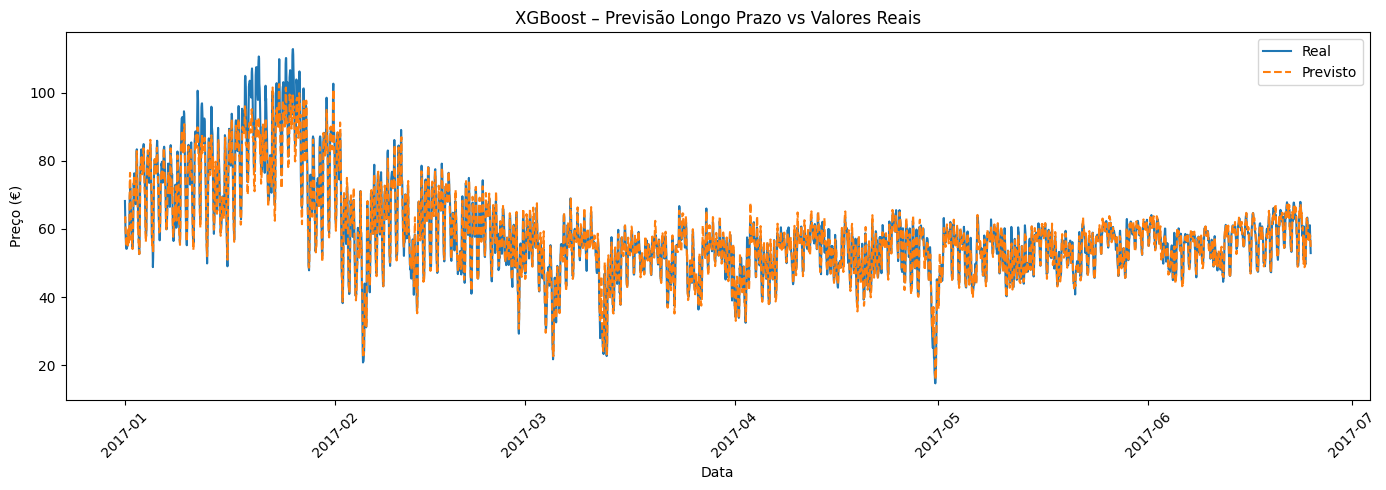

MAE         1.9003
RMSE        2.5309
MAPE (%)    3.1935
rMAE        0.0311
dtype: float64


In [12]:
import matplotlib.pyplot as plt

def longterm_sliding_expanding_tunning_xgb(
    df,
    train_start,
    train_end,
    test_start,
    test_end,
    forecast_horizon=168,
    n_estimators=300,
    learning_rate=0.05,
    max_depth=8,
    subsample=1.0,
    colsample_bytree=1.0,
    gamma=0,
    random_state=42
):
    from xgboost import XGBRegressor
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
    import numpy as np
    import pandas as pd

    df = df.copy()
    df.index = df.index.tz_localize(None)

    current_test_start = pd.to_datetime(test_start)
    final_test_end = pd.to_datetime(test_end)

    results = []
    all_preds = []
    all_truths = []
    all_dates = []

    total_steps = ((final_test_end - current_test_start).days + 1) // 7
    checkpoints = {int(total_steps * 0.25): "25%", int(total_steps * 0.5): "50%", int(total_steps * 0.75): "75%"}

    step = 0
    while current_test_start + pd.Timedelta(hours=forecast_horizon - 1) <= final_test_end:
        if step in checkpoints:
            print(f"⏳ Progresso: {checkpoints[step]} da janela de teste")

        current_test_end = current_test_start + pd.Timedelta(hours=forecast_horizon - 1)
        df_train = df.loc[train_start:current_test_start - pd.Timedelta(hours=1)]
        df_test = df.loc[current_test_start:current_test_end]

        drop_cols = ['price actual', 'price day ahead']
        feature_cols = [col for col in df.columns if col not in drop_cols]

        X_train = df_train[feature_cols].values
        y_train = df_train['price actual'].values
        X_test = df_test[feature_cols].values
        y_test = df_test['price actual'].values

        scaler_X = StandardScaler()
        scaler_y = StandardScaler()
        X_train_scaled = scaler_X.fit_transform(X_train)
        X_test_scaled = scaler_X.transform(X_test)
        y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()

        model = XGBRegressor(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            gamma=gamma,
            random_state=random_state,
            n_jobs=-1
        )
        model.fit(X_train_scaled, y_train_scaled)

        y_pred_scaled = model.predict(X_test_scaled)
        y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

        # Guardar para gráfico
        all_preds.extend(y_pred)
        all_truths.extend(y_test)
        all_dates.extend(df_test.index)

        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mape = mean_absolute_percentage_error(y_test, y_pred) * 100
        rmae = mae / np.mean(np.abs(y_test))

        results.append({
            'start': current_test_start,
            'end': current_test_end,
            'MAE': mae,
            'RMSE': rmse,
            'MAPE (%)': mape,
            'rMAE': rmae
        })

        current_test_start += pd.Timedelta(hours=forecast_horizon)
        step += 1

    # Gerar gráfico
    if all_preds:
        plt.figure(figsize=(14, 5))
        plt.plot(all_dates, all_truths, label='Real', linewidth=1.5)
        plt.plot(all_dates, all_preds, label='Previsto', linestyle='--', linewidth=1.5)
        plt.title("XGBoost – Previsão Longo Prazo vs Valores Reais")
        plt.xlabel("Data")
        plt.ylabel("Preço (€)")
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    return pd.DataFrame(results)

xgb_forecast_results = longterm_sliding_expanding_tunning_xgb(
    df=df_prepared,
    train_start='2015-01-01',
    train_end='2016-12-31',
    test_start='2017-01-01',
    test_end='2017-06-30',  # 6 meses
    forecast_horizon=168,
    n_estimators=300,
    learning_rate=0.05,
    max_depth=8
)

print(xgb_forecast_results[['MAE', 'RMSE', 'MAPE (%)', 'rMAE']].mean().round(4))


⏳ Progresso: 25% da janela de teste
⏳ Progresso: 50% da janela de teste
⏳ Progresso: 75% da janela de teste


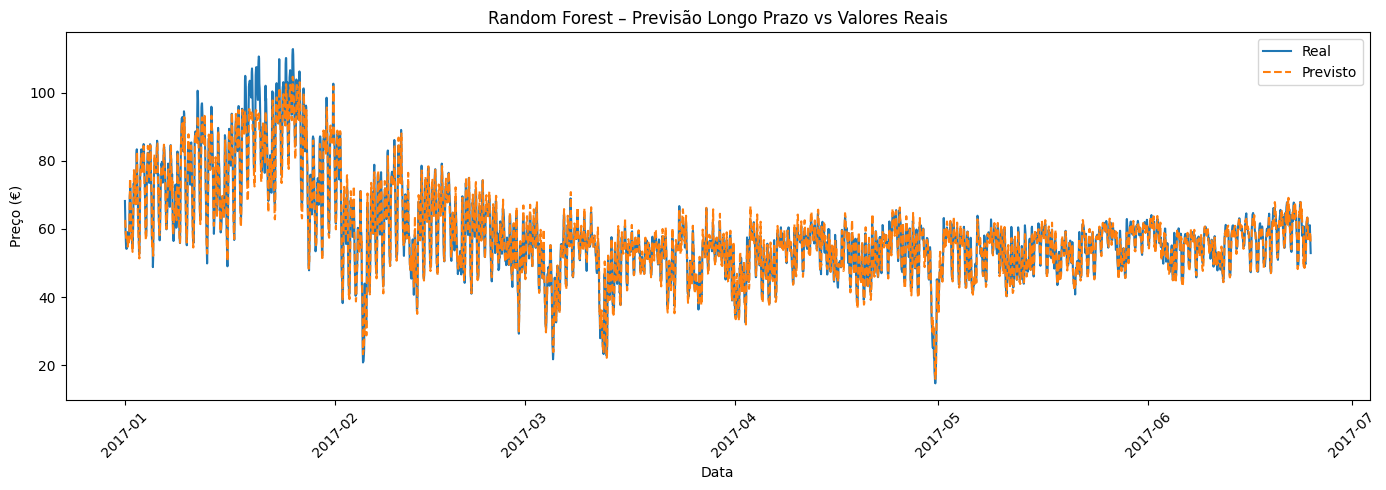

MAE         1.8865
RMSE        2.4901
MAPE (%)    3.2302
rMAE        0.0314
dtype: float64


In [13]:
import matplotlib.pyplot as plt

def longterm_sliding_expanding_rf_tunning(
    df,
    train_start,
    train_end,
    test_start,
    test_end,
    forecast_horizon=168,
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
):
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
    import numpy as np
    import pandas as pd

    df = df.copy()
    df.index = df.index.tz_localize(None)

    current_test_start = pd.to_datetime(test_start)
    final_test_end = pd.to_datetime(test_end)

    results = []
    all_preds = []
    all_truths = []
    all_dates = []

    total_steps = ((final_test_end - current_test_start).days + 1) // 7
    checkpoints = {int(total_steps * 0.25): "25%", int(total_steps * 0.5): "50%", int(total_steps * 0.75): "75%"}

    step = 0
    while current_test_start + pd.Timedelta(hours=forecast_horizon - 1) <= final_test_end:
        if step in checkpoints:
            print(f"⏳ Progresso: {checkpoints[step]} da janela de teste")

        current_test_end = current_test_start + pd.Timedelta(hours=forecast_horizon - 1)

        df_train = df.loc[train_start:current_test_start - pd.Timedelta(hours=1)]
        df_test = df.loc[current_test_start:current_test_end]

        drop_cols = ['price actual', 'price day ahead']
        feature_cols = [col for col in df.columns if col not in drop_cols]

        X_train = df_train[feature_cols].values
        y_train = df_train['price actual'].values
        X_test = df_test[feature_cols].values
        y_test = df_test['price actual'].values

        scaler_X = StandardScaler()
        scaler_y = StandardScaler()
        X_train_scaled = scaler_X.fit_transform(X_train)
        X_test_scaled = scaler_X.transform(X_test)
        y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()

        model = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=random_state,
            n_jobs=-1
        )
        model.fit(X_train_scaled, y_train_scaled)

        y_pred_scaled = model.predict(X_test_scaled)
        y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

        # Guardar para gráfico
        all_preds.extend(y_pred)
        all_truths.extend(y_test)
        all_dates.extend(df_test.index)

        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mape = mean_absolute_percentage_error(y_test, y_pred) * 100
        rmae = mae / np.mean(np.abs(y_test))

        results.append({
            'start': current_test_start,
            'end': current_test_end,
            'MAE': mae,
            'RMSE': rmse,
            'MAPE (%)': mape,
            'rMAE': rmae
        })

        current_test_start += pd.Timedelta(hours=forecast_horizon)
        step += 1

    # Gráfico final
    if all_preds:
        plt.figure(figsize=(14, 5))
        plt.plot(all_dates, all_truths, label='Real', linewidth=1.5)
        plt.plot(all_dates, all_preds, label='Previsto', linestyle='--', linewidth=1.5)
        plt.title("Random Forest – Previsão Longo Prazo vs Valores Reais")
        plt.xlabel("Data")
        plt.ylabel("Preço (€)")
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    return pd.DataFrame(results)

rf_forecast_results = longterm_sliding_expanding_rf_tunning(
    df=df_prepared,
    train_start='2015-01-01',
    train_end='2016-12-31',
    test_start='2017-01-01',
    test_end='2017-06-30',  # 6 meses
    forecast_horizon=168,
    n_estimators=300,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2
)

print(rf_forecast_results[['MAE', 'RMSE', 'MAPE (%)', 'rMAE']].mean().round(4))
